In [2]:
import sys, os
import pandas as pd
import numpy as np
import json
import re
import warnings
import math
warnings.simplefilter(action='ignore', category=FutureWarning)
import os, glob
import pickle
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from pretty_confusion_matrix import pp_matrix, pp_matrix_from_data

In [3]:
pd.options.mode.chained_assignment = None
data_folder = "../Captures/Data_11_9"
data_path = os.path.abspath(data_folder)
ip = '192.168.1.187'
first_run = True
video_size_thresh = 400
preferred_lookback = {'meet': 2, 'teams': 2}
size_diff_threshold = {'meet': 20, 'teams': 3}
csv_columns = ['frame.time_relative','frame.time_epoch','ip.src','ip.dst','ip.proto','ip.len','udp.srcport','udp.dstport', 'udp.length','rtp.ssrc','rtp.timestamp','rtp.seq','rtp.p_type']

In [4]:
%run "../scripts/helper_functions.py"

## Preprocessing

In [5]:
def filter_ptype(x):
    if type(x) != str and math.isnan(x):
        return x
    x = str(x)
    if ',' in x:
        return str(int(float(x.split(',')[0])))
    return str(int(float(x)))

def label_video_non_rtp(df_trace):
    df_trace['is_video_pred'] = 0
    is_in_range = ((df_trace['udp.length'] > video_size_thresh))
    df_trace.loc[is_in_range, 'is_video_pred'] = 1
    df_trace.loc[~is_in_range, 'is_video_pred'] = 0
    return df_trace

def label_video_rtp(df_trace):
    results = []
    df_trace['is_video_actual'] = 0
    top_two = df_trace.groupby(['rtp.p_type'])['udp.length'].mean().nlargest(2).index.tolist()
    condition = ((df_trace['rtp.p_type'].isin(top_two)) & ((df_trace['udp.length'] > video_size_thresh)))
    df_trace.loc[condition, 'is_video_actual'] = 1
    df_trace.loc[~condition, 'is_video_actual'] = 0
    return df_trace

def preprocess_trace(filename):
    df_net = pd.read_csv(filename, header=None, sep='\t', names=csv_columns, lineterminator='\n', encoding='ascii')
    vca = filename.split('/')[-1].split('-')[0]
    df_net['vca'] = vca
    df_net = df_net[(df_net["ip.dst"] == ip) & (~pd.isna(df_net["rtp.ssrc"]))]
    df_net['rtp.p_type'] = df_net['rtp.p_type'].apply(filter_ptype)
    df_rtp = df_net[~pd.isna(df_net["rtp.p_type"])]
    df_rtp = label_video_rtp(df_rtp)
    df_rtp = label_video_non_rtp(df_rtp)
    return df_rtp

def get_frames(df_rtp):
    df_video = df_rtp[df_rtp['is_video_actual'] == 1]
    df_grp = df_video.groupby('rtp.timestamp').agg({"udp.length": list, "rtp.p_type": list, "frame.time_relative": list}).reset_index()
    return df_grp

## Inference

In [6]:
th_pattern = re.compile('^chrome\-\d*\-0\-0\-0\-0\-0\-[0-9]+\-[0-9]+\.json')
sd_th_pattern = re.compile('^chrome\-5\-\d*\.\d*\-0\-0\-0\-0\-[0-9]+\-[0-9]+\.json')
lat_pattern = re.compile('^chrome\-5\-0\-\d*\-0\-0\-0\-[0-9]+\-[0-9]+\.json')
sd_lat_pattern = re.compile('^chrome\-5\-0\-50\-\d*\-0\-0\-[0-9]+\-[0-9]+\.json')
loss_pattern = re.compile('^chrome\-5\-0\-50\-0\-[0-9]\-0\-[0-9]+\-[0-9]+\.json')
sd_loss_pattern = re.compile('^chrome\-[0-9]\-0\-50\-0\-2\-\d*\.\d*\-[0-9]+\-[0-9]+\.json')
patterns = [th_pattern, sd_th_pattern, lat_pattern, sd_lat_pattern , loss_pattern , sd_loss_pattern]

### Train test split

In [7]:
all_files = {'meet': {}, 'teams': {}}

meet_train_files = []
meet_test_files = []
teams_train_files = []
teams_test_files = []

for dirname in os.listdir(data_folder):
    vca = dirname.split('_')[1]
    csv_filename = glob.glob(f"{data_folder}/{dirname}/{vca}/captures/*.csv")[0]
    webrtc_filename = glob.glob(f"{data_folder}/{dirname}/{vca}/webrtc/*.json")[0]
    config = '-'.join(webrtc_filename.split('/')[-1].split('-')[1:7])
    if config not in all_files[vca]:
        all_files[vca][config] = []
    all_files[vca][config].append((csv_filename, webrtc_filename))

for vca in ['teams', 'meet']:
    for config in all_files[vca]:
        n = len(config)//2
        f = all_files[vca][config]
        if vca == 'meet':
            meet_train_files += f[:1]
            meet_test_files += f[1:2]
        else:
            teams_train_files += f[:1]
            teams_test_files += f[1:2]

### Estimation functions

In [47]:
df_columns = ['vca', 'is_video_actual', 'is_video_pred', 'relative_frame_id_diff', 'D1', 'D2', 'S1', 'S2', 'frame.time_relative', 'frame.time_epoch', 'ip.src', 'ip.dst', 'ip.proto', 'ip.len', 'udp.srcport', 'udp.dstport', 'udp.length', 'rtp.ssrc', 'rtp.timestamp']

def label_trace(filename):
    df = preprocess_trace(filename)
    print(1, len(df))
    # Generate an ordering of RTP timestamps
    df['rtp.timestamp'] = df['rtp.timestamp'].astype(int)
    df = df[~df['rtp.p_type'].isna()]
    df_video = df[df['is_video_actual'] == 1]
    df_video['relative_frame_id_diff'] = 0
    diff_cols = []
    vca = filename.split('/')[-1].split('-')[0]
    for l in range(1, preferred_lookback[vca]+1):
        df_video[f'D{l}'] = 0.0
        df_video[f'T{l}'] = 0.0
        df_video[f'S{l}'] = 0.0
    
    ts_list = list(set(df_video['rtp.timestamp']))
    ts_list.sort()
    mapping = {x:i for i, x in enumerate(ts_list)}
    df_grp = df_video.groupby('rtp.timestamp').agg({'udp.length': list, 'frame.time_relative': list}).reset_index()
    max_rel_id = mapping[df_video.iloc[0]['rtp.timestamp']]
    count = 0
    for i, row in df_video.iterrows():
        if count == 0:
            count += 1
            continue
        rel_id_diff = mapping[row['rtp.timestamp']] - max_rel_id
        # if rel_id_diff < -2:
        #     rel_id_diff = -2
        # elif rel_id_diff > 1:
        #     rel_id_diff = 1
        df_video.at[i, 'relative_frame_id_diff'] = rel_id_diff
        max_rel_id = max(mapping[row['rtp.timestamp']], max_rel_id)
        for l in range(1, preferred_lookback[vca]+1):
            if mapping[row['rtp.timestamp']]-l < 0:
                continue
            prev_ts = ts_list[mapping[row['rtp.timestamp']]-l]
            df_video.at[i, f'D{l}'] = abs(np.array(df_grp.loc[df_grp['rtp.timestamp'] == prev_ts].iloc[0]['udp.length']).mean()-row['udp.length'])
            df_video.at[i, f'T{l}'] = max(df_grp.loc[df_grp['rtp.timestamp'] == prev_ts].iloc[0]['frame.time_relative'])-row['frame.time_relative']
            df_video.at[i, f'S{l}'] = np.array(df_grp.loc[df_grp['rtp.timestamp'] == prev_ts].iloc[0]['udp.length']).std()
            # print(df_video.at[i, f'D{l}'], df_video.at[i, f'T{l}'])
        count += 1
    return df_video[df_columns]

def make_predictions(filename, model):
    df = preprocess_trace(filename)
    df['rtp.timestamp'] = df['rtp.timestamp'].astype(int)
    df.dropna(axis=0, inplace=True)
    df_video = df[df['is_video_pred'] == 1]
    df_video['pred_frame_id'] = 0
    diff_cols = []
    vca = filename.split('/')[-1].split('-')[0]
    for l in range(1, preferred_lookback[vca]+1):
        df_video[f'D{l}'] = 0.0
        df_video[f'T{l}'] = 0.0
        df_video[f'S{l}'] = 0.0
        diff_cols.append(f'D{l}')
    assigned_frames = {0: [[df_video.iloc[0]['udp.length']], [df_video.iloc[0]['frame.time_relative']]]} # Sum, count and rel_time of last packet
    max_assigned = 0
    count = 0
    for i, row in df_video.iterrows():
        if count == 0:
            count += 1
            continue
        for l in range(1, preferred_lookback[vca]+1):
            if max_assigned-l < 0:
                continue
            prev_frame_id = max_assigned-l
            prev_avg = np.array(assigned_frames[prev_frame_id][0]).mean()
            df_video.at[i, f'D{l}'] = abs(prev_avg-row['udp.length'])
            df_video.at[i, f'T{l}'] = assigned_frames[prev_frame_id][1][-1]-row['frame.time_relative']
            df_video.at[i, f'S{l}'] = np.array(assigned_frames[prev_frame_id][0]).std()
            
        pred = model.predict(df_video.loc[i, ['D1', 'D2', 'S1', 'S2', 'frame.time_relative', 'udp.length']].to_numpy().reshape(-1, 1).T)
        # print(df_video.loc[i, ['D0', 'D1', 'D2', 'T0', 'T1', 'T2']].to_numpy().reshape(-1, 1).T, pred)
        df_video.at[i, 'model_output'] = pred
        df_video.at[i, 'pred_frame_id'] = pred + max_assigned
        if df_video.loc[i]['pred_frame_id'] not in assigned_frames:
            assigned_frames[df_video.loc[i]['pred_frame_id']] = [[0], [0]]
        assigned_frames[df_video.loc[i]['pred_frame_id']][0].append(row['udp.length'])
        assigned_frames[df_video.loc[i]['pred_frame_id']][1].append(max(assigned_frames[df_video.loc[i]['pred_frame_id']][1][-1], row['frame.time_relative']))
        max_assigned = max(max_assigned, df_video.loc[i]['pred_frame_id'])
        # print('max assigned = ', max_assigned)
        # print(assigned_frames[row['pred_frame_id']])
        count += 1
    return df_video
            
def is_freeze(x):
    if x["frame_dur"] > max(3*x["avg_frame_dur"], (x["avg_frame_dur"] + 0.150)): # Q: Based on previous work or experiments?
        return 1
    else:
        return 0

def get_freeze_dur(x):
    if x["is_freeze"] == 1:
        return x["frame_dur"]
    else:
        return 0
    

def get_net_stats(df_video, vca, ft_end_col="frame_et"):
    ## frame duration calculations
    df_video["frame_st"] = df_video["frame_st"].apply(lambda x: float(x))
    df_video["frame_et"] = df_video["frame_et"].apply(lambda x: float(x))
    df_video["frame_size"] = df_video["frame_size"].apply(lambda x: float(x))
    df_video["frame_dur"] = df_video[ft_end_col].diff()
    df_video["avg_frame_dur"] = df_video["frame_dur"].rolling(30).mean()
    df_video = df_video.fillna(0)
    
    ## freeze calculation
    df_video["is_freeze"] = df_video.apply(is_freeze, axis=1)
    df_video["freeze_dur"] = df_video.apply(get_freeze_dur, axis=1)
    
    ## obtain per second stats
    df_video["frame_et_int"] = df_video[ft_end_col].apply(lambda x: int(x))
    df_grp = df_video.groupby("frame_et_int").agg({"frame_size" : ["count", "sum"], "is_freeze": "sum", 
                                             "freeze_dur": "sum", "frame_dur": "std"}).reset_index()
    
    ## rename columns
    df_grp.columns = ['_'.join(col).strip('_') for col in df_grp.columns.values]    
    df_grp = df_grp.rename(columns={'frame_size_count': 'fps',
                                    'is_freeze_sum': 'freeze_count',
                                    'frame_size_sum': 'bitrate',
                                    'freeze_dur_sum': 'freeze_dur',
                                    'lost_frame_sum': 'frames_lost',
                                    'frame_dur_std': 'interframe_delay_std'
                                   })
    df_grp['bitrate'] = df_grp['bitrate']*8/1000    
    return df_grp

def calculate_metrics(df, method):
    df['udp.length'] = df['udp.length'] - 12
    df_grp = df.groupby("pred_frame_id").agg({"frame.time_epoch": list, "udp.length": list}).reset_index()
    df_grp["frame_st"] = df_grp["frame.time_epoch"].apply(lambda x: min(x))
    df_grp["frame_et"] = df_grp["frame.time_epoch"].apply(lambda x: max(x))
    df_grp["frame_size"] = df_grp["udp.length"].apply(lambda x: sum(x))
    df_grp["frame_length"] = df_grp["udp.length"].apply(lambda x: len(x))
    
    # print(df_grp[df_grp['frame_et'].isna()])
    
    # print(df_grp['frame_et'])

    df_grp["ft_end"] = df_grp['frame_et'].apply(lambda x: int(x))
    
    frame_lengths = df_grp['frame_length']
    frame_sizes = df_grp['frame_size']
    
    ## frame duration calculations
    df_grp["frame_dur"] = df_grp["frame_et"].diff()
    df_grp["avg_frame_dur"] = df_grp["frame_dur"].rolling(30).mean() # Why 30?
    df_grp = df_grp.fillna(0)
    
    ## freeze calculation
    df_grp["is_freeze"] = df_grp.apply(is_freeze, axis=1)
    df_grp["freeze_dur"] = df_grp.apply(get_freeze_dur, axis=1)
    
    
    
    df_grp = df_grp.groupby("ft_end").agg({"frame_size" : ["count", "sum"], "is_freeze": "sum", 
                                             "freeze_dur": "sum", 
                                            "frame_dur": "std"}).reset_index()
    
    ## rename columns
    df_grp.columns = ['_'.join(col).strip('_') for col in df_grp.columns.values]    
    df_grp = df_grp.rename(columns={'frame_size_count': 'fps',
                                    'is_freeze_sum': 'freeze_count',
                                    'frame_size_sum': 'bitrate',
                                    'freeze_dur_sum': 'freeze_dur',
                                    'frame_dur_std': 'interframe_delay_std'
                                   })
    df_grp['bitrate'] = df_grp['bitrate']*8/1000
    df_grp['method'] = method
    return df_grp

def get_merged_stats(model, csv_file, webrtc_file):
    df_rtp = extract_features(csv_file)
    # print(df_rtp[df_rtp['udp.length'].isna()])
    df_rtp.dropna(inplace=True)
    # print(df_rtp[df_rtp['udp.length'].isna()])
    df_webrtc = get_webrtc(webrtc_file)
    X = df_rtp[['D1', 'D2']]
    y = model.predict(X)
    df_rtp['rel_ts'] = y
    df_rtp['pred_frame_id'] = 0
    for i in range(1, df_rtp.shape[0]):
        df_rtp.at[i, 'pred_frame_id'] = df_rtp.iloc[i-1]['pred_frame_id']+df_rtp.iloc[i-1]['rel_ts']
    df_grp_udp = calculate_metrics(df_rtp, 'ML')
    df_grp_rtp = df_rtp.groupby("rtp.timestamp").agg({"frame.time_epoch": list, "udp.length": list}).reset_index()
    df_grp_rtp["frame_st"] = df_grp_rtp["frame.time_epoch"].apply(lambda x: min(x))
    df_grp_rtp["frame_et"] = df_grp_rtp["frame.time_epoch"].apply(lambda x: max(x))
    df_grp_rtp["frame_size"] = df_grp_rtp["udp.length"].apply(lambda x: sum(x))
    col = "ft_end"
    df_merge_udp = pd.merge(df_grp_udp, df_webrtc, left_on=col, right_on="ts")
    col = "frame_et_int"
    vca = csv_file.split('/')[-1].split('-')[0]
    df_grp_rtp = get_net_stats(df_grp_rtp, vca=vca)
    df_merge_rtp = pd.merge(df_grp_rtp, df_webrtc, left_on=col, right_on="ts")
    return df_merge_rtp, df_merge_udp

### Merge and Lookback Approach

In [ ]:
from itertools import combinations

def merge(arr):
    cont = True
    while cont:
        res = []
        for a, b in combinations(arr):
            arr1 = np.array(arr[a])
            arr2 = np.array(arr[b])
            st_0 = min(arr1.std(), arr2.std())
            st_1 = np.concat([arr1, arr2]).std()
            if st_1 - st_0 <= 3:
                res.append(arr[a]+arr[b])
            else:
                res.append(arr[a])
                res.append(arr[b])
        
def merge_and_lookback(packet_sizes):
    res = [[x] for x in packet_sizes]
    prev_stdev = 0
    cur_stdev = 100000
    while prev_stdev - cur_stdev > 1:
        merged_frames = []
        while idx in range(0, len(res), 5):
            merged_frames += merge(res[idx:idx+5])
        res = merged_frames
        prev_stdev = cur_stdev
        cur_stdev = np.array(res).std(1).mean()

In [48]:
teams_train_data = []
teams_test_data = []
for i, f in enumerate(teams_train_files[:3]+teams_train_files[5:12]):
    print('Train', i+1, 'of 10')
    teams_train_data.append(label_trace(f[0]))
teams_train = pd.concat(teams_train_data, axis=0)
teams_train.to_csv('../Intermediates/teams_train.csv')
# for i, f in enumerate(teams_test_files[:10]):
#     print('Test', i+1, 'of 10')
#     teams_test_data.append(label_trace(f[0]))
# teams_test = pd.concat(teams_test_data, axis=0)
# teams_test.to_csv('../Intermediates/teams_test.csv')

Train 1 of 10
1 6562
Train 2 of 10
1 5583
Train 3 of 10
1 7006
Train 4 of 10
1 6196
Train 5 of 10
1 6187
Train 6 of 10
1 6014
Train 7 of 10
1 5689
Train 8 of 10
1 6418
Train 9 of 10
1 6608
Train 10 of 10
1 6123


In [49]:
# teams_train = pd.read_csv('../Intermediates/teams_train.csv')
from sklearn.tree import DecisionTreeClassifier

train_data = teams_train[['D1', 'D2', 'S1', 'S2', 'frame.time_relative', 'udp.length', 'relative_frame_id_diff']]
train_data.dropna(inplace=True)
X_train = train_data[['D1', 'D2', 'S1', 'S2', 'frame.time_relative', 'udp.length']]
y_train = train_data['relative_frame_id_diff']

teams_model = RandomForestClassifier()
teams_model.fit(X_train.to_numpy(), y_train)

RandomForestClassifier()

In [50]:
teams_train.head(10)

,vca,is_video_actual,is_video_pred,relative_frame_id_diff,D1,D2,S1,S2,frame.time_relative,frame.time_epoch,ip.src,ip.dst,ip.proto,ip.len,udp.srcport,udp.dstport,udp.length,rtp.ssrc,rtp.timestamp
168,teams,1,1,0,0.0,0.0,0.0,0.0,1.711989,1.667880e+09,52.113.213.121,192.168.1.187,17,951,3480.0,43075.0,931.0,0x0002176f,197361354
169,teams,1,1,0,0.0,0.0,0.0,0.0,1.713465,1.667880e+09,52.113.213.121,192.168.1.187,17,951,3480.0,43075.0,931.0,0x0002176f,197361354
178,teams,1,1,0,0.0,0.0,0.0,0.0,1.739152,1.667880e+09,52.113.213.121,192.168.1.187,17,951,3480.0,43075.0,931.0,0x0002176f,197361354
212,teams,1,1,1,151.0,0.0,0.0,0.0,2.208635,1.667880e+09,52.113.213.121,192.168.1.187,17,1102,3480.0,43075.0,1082.0,0x0002176f,197406423
226,teams,1,1,1,235.0,84.0,0.0,0.0,2.783502,1.667880e+09,52.113.213.121,192.168.1.187,17,867,3480.0,43075.0,847.0,0x0002176f,197458099
227,teams,1,1,0,235.0,84.0,0.0,0.0,2.784908,1.667880e+09,52.113.213.121,192.168.1.187,17,867,3480.0,43075.0,847.0,0x0002176f,197458099
256,teams,1,1,1,262.0,497.0,0.0,0.0,2.928043,1.667880e+09,52.113.213.121,192.168.1.187,17,605,3480.0,43075.0,585.0,0x0002176f,197471697
269,teams,1,1,1,186.0,76.0,0.0,0.0,3.088749,1.667880e+09,52.113.213.121,192.168.1.187,17,791,3480.0,43075.0,771.0,0x0002176f,197486045
282,teams,1,1,1,232.0,46.0,0.0,0.0,3.213387,1.667880e+09,52.113.213.121,192.168.1.187,17,559,3480.0,43075.0,539.0,0x0002176f,197496918
286,teams,1,1,1,273.0,41.0,0.0,0.0,3.378445,1.667880e+09,52.113.213.121,192.168.1.187,17,832,3480.0,43075.0,812.0,0x0002176f,197512136


In [51]:
# import graphviz
# from sklearn import tree
# # DOT data
# dot_data = tree.export_graphviz(teams_model, out_file=None, 
#                                 feature_names=['D1', 'D2', 'T0', 'T1', 'T2', 'S0', 'S1', 'S2', 'frame.time_relative', 'udp.length'],  
#                                 class_names=list(map(str, teams_train['relative_frame_id_diff'].unique())),
#                                 filled=True)

# # Draw graph
# graph = graphviz.Source(dot_data, format="png") 
# graph.render("plots/decision_tree_graphviz")

In [52]:
y_train.unique()

array([  0,   1,  -1,  -2, -20, -18, -17, -16, -15, -14, -13, -12, -11,
        -9,  -8,  -7,  -6,  -5,  -4,  -3, -48, -47, -46, -43, -41, -40,
       -38, -37, -36, -35, -33, -32, -31, -29, -27, -26, -25, -23, -22,
       -21, -19, -10])

In [53]:
# teams_train[(teams_train['relative_frame_id_diff'] == 1)&(teams_train['D1'] == 0)&(teams_train['D2'] == 0)]

In [54]:
teams_train['relative_frame_id_diff'].value_counts()

 0     45913
 1      6138
-1      5553
-2       446
-4        76
-3        65
-5        32
-9        30
-13       24
-12       22
-8        19
-11       17
-7        15
-10       13
-14       13
-6        12
-16       12
-17       12
-15       12
-18        8
-22        8
-40        5
-26        4
-33        4
-37        4
-36        4
-46        4
-20        4
-41        3
-32        3
-31        3
-25        3
-48        3
-21        3
-38        2
-43        2
-35        2
-29        2
-27        2
-23        2
-19        2
-47        2
Name: relative_frame_id_diff, dtype: int64

In [56]:
df = make_predictions(teams_test_files[1][0], teams_model)
df['pred_frame_id'].unique()

array([0, 1, 2])

In [57]:
df['model_output'].unique()

array([nan,  0.,  1.])

In [46]:
df[df['model_output'].isna()]

,frame.time_relative,frame.time_epoch,ip.src,ip.dst,ip.proto,ip.len,udp.srcport,udp.dstport,udp.length,rtp.ssrc,...,is_video_actual,is_video_pred,pred_frame_id,D1,T1,S1,D2,T2,S2,model_output
300,3.228691,1.667872e+09,52.115.167.142,192.168.1.187,17,1264,3478.0,59665.0,1244.0,0x00013ccd,...,1,1,0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [ ]:
meet_train_data = []
meet_test_data = []
for i, f in enumerate(meet_train_files[:10]):
    print('Train', i+1, 'of 10')
    meet_train_data.append(extract_features(f[0]))
meet_train = pd.concat(meet_train_data, axis=0)
meet_train.to_csv('../Intermediates/meet_train.csv')
for i, f in enumerate(meet_test_files[:10]):
    print('Test', i+1, 'of 10')
    meet_test_data.append(extract_features(f[0]))
meet_test = pd.concat(meet_test_data, axis=0)
meet_test.to_csv('../Intermediates/meet_test.csv')

# meet_train = pd.read_csv('../Intermediates/meet_train.csv')

train_data = meet_train[['D1', 'D2', 'relative_frame_id']]
train_data.dropna(inplace=True)
X_train = train_data[['D1', 'D2']]
y_train = train_data['relative_frame_id']

# meet_test = pd.read_csv('../Intermediates/meet_test.csv')

test_data = meet_test[['D1', 'D2', 'relative_frame_id']]
test_data.dropna(inplace=True)
X_test = test_data[['D1', 'D2']]
y_test = test_data['relative_frame_id']

meet_model = RandomForestClassifier()
meet_model.fit(X_train, y_train)
y_pred = meet_model.predict(X_test)
print(accuracy_score(y_pred, y_test))

In [ ]:
test_file = teams_train_files[11]
dr, du = get_predictions(teams_model, test_file[0], test_file[1])

interval = 1

df_grp_webrtc = du['framesPerSecond'].rolling(interval).mean()
# df_grp_webrtc = df_grp_webrtc[~df_grp_webrtc.isna()]

df_grp_udp = du['fps'].rolling(interval).mean()
# df_grp_rtp = df_grp_rtp[~df_grp_rtp.isna()]

df_grp_rtp = dr['fps'].rolling(interval).mean()
# df_grp_udp = df_grp_udp[~df_grp_udp.isna()]

## Inaccuracy checks

In [4]:
def get_violations_per_frame(l, vca):
    count = 0
    for i in range(1, len(l)):
        cur_diff = abs(l[i] - l[i-1])
        if cur_diff > size_diff_threshold[vca]:
            count += 1
    return count

def get_violations_with_lookback(df_grp, vca):
    v = [0]
    for idx, frame in df_grp.iterrows():
        if idx == 0:
            continue
        for pkt in frame['udp.length']:
            prev_avgs = [np.array(df_grp.iloc[idx-j]['udp.length']).mean() for j in range(1, preferred_lookback[vca]+1) if idx-j > 0]
            count = 0
            vfound = False
            for a in prev_avgs:
                if abs(a-pkt) <= size_diff_threshold[vca]:
                    vfound = True
                    break
            if vfound:
                count += 1
        v.append(count)
    return v
        
def get_thresh_violations(filename, with_lookback=False):
    df_rtp = preprocess_trace(filename)
    vca = df_rtp['vca'].unique()[0]
    df_grp = get_frames(df_rtp)
    if with_lookback:
        df_grp['lookback_violations'] = get_violations_with_lookback(df_grp, vca)
        return df_grp['lookback_violations'], len(df_rtp)
    else:
        df_grp['num_violations'] = df_grp['udp.-length'].apply(lambda x: get_violations_per_frame(x, vca))
        print(df_grp[df_grp['num_violations'] >= 1][['udp.length', 'num_violations']])
        return df_grp['num_violations'], len(df_rtp)
    
def get_packet_reorders(filename):
    df_rtp = preprocess_trace(filename)
    vca = df_rtp['vca'].unique()[0]
    df_rtp['rtp.ts_rel'] = 0
    rtp_ts = {}
    count = 0
    for idx, row in df_rtp.iterrows():
        if row['rtp.timestamp'] not in rtp_ts:
            rtp_ts[row['rtp.timestamp']] = len(rtp_ts)+1
        else:
            if len(rtp_ts)-rtp_ts[row['rtp.timestamp']] >= preferred_lookback[vca]:
                count += 1
        df_rtp.at[idx, 'rtp.ts_rel'] = rtp_ts[row['rtp.timestamp']]
    return count
    
def plot_media_classification(filename):
    df_rtp = preprocess_trace(filename)
    cm = confusion_matrix(df_rtp["is_video_actual"], df_rtp["is_video_pred"])
    np.set_printoptions(3)
    cm_frac = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_frac, annot=True)

In [35]:
test_file = '/data/vca-qoe-inference/data/Data_11_9/2022-11-07_teams_3_0_0_0_0_0_1667867246/teams/webrtc/chrome-3-0-0-0-0-0-1667867246-1667867318.json'

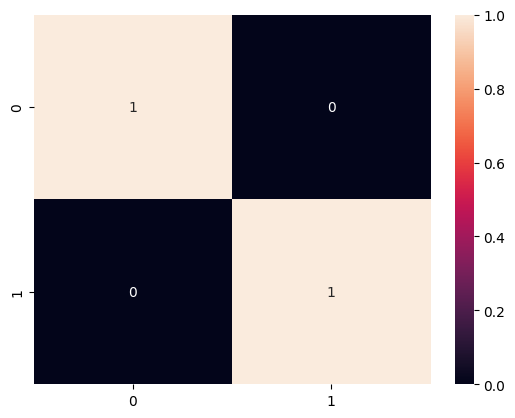

In [36]:
plot_media_classification(test_file)

In [37]:
pd.options.display.max_colwidth = 1000
pd.options.display.max_rows = 1000
tv, total_packets = get_thresh_violations(test_file)
tv_perc = round(100*sum(tv)/total_packets, 2)
print('Total threshold violations = ', sum(tv), f'({tv_perc}% of total packets)')
lb = len(tv)
tv = np.array(tv)
print(len(tv[tv > 0])/lb)

Empty DataFrame
Columns: [udp.length, num_violations]
Index: []
Total threshold violations =  0 (0.0% of total packets)
0.0


In [38]:
lv, total_packets = get_thresh_violations(test_file, with_lookback=True)
lv_perc = round(100*sum(lv)/total_packets, 2)
print('Total threshold violations with lookback = ', sum(lv), f'({lv_perc}% of total packets)')
lb = len(lv)
lv = np.array(lv)
print(len(lv[lv > 0])/lb)

Total threshold violations with lookback =  34 (0.99% of total packets)
0.0451527224435591


In [39]:
reorders = get_packet_reorders(test_file)
reord_perc = round(100*reorders/total_packets, 2)
print('Number of packet reorders = ', reorders, f'({reord_perc}% of total packets)')

Number of packet reorders =  677 (19.75% of total packets)


In [72]:
rtc_dfs = []

for dirname in os.listdir('../Captures/Data_11_9/'):
    vca = dirname.split('_')[1]
    webrtc_filename = glob.glob(f"../Captures/Data_11_9/{dirname}/{vca}/webrtc/*.json")[0]
    rtc_df = get_webrtc(webrtc_filename)
    rtc_df['file'] = webrtc_filename.split('/')[-1]
    rtc_df['vca'] = vca
    rtc_dfs.append(rtc_df)

rtc = pd.concat(rtc_dfs)
rtc['diff'] = rtc['framesPerSecond']-rtc['framesReceived']

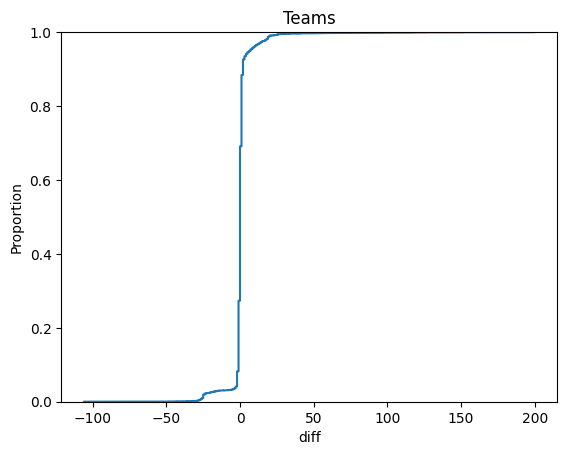

In [85]:
rtc_teams = rtc[rtc['vca'] == 'teams']['diff']
sns.ecdfplot(data = rtc_teams).set_title('Teams')
plt.savefig('plots/fps_diff_teams.png')

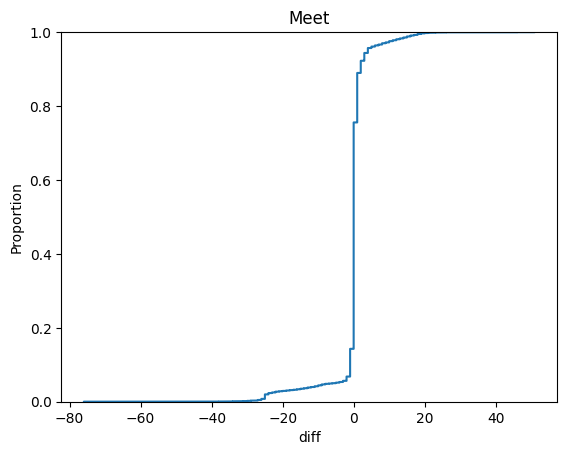

In [86]:
rtc_teams = rtc[rtc['vca'] == 'meet']['diff']
sns.ecdfplot(data = rtc_teams).set_title('Meet')
plt.savefig('plots/fps_diff_meet.png')